In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
import skimage.exposure

plt.rc('image', cmap='gray')  # set default cmap from viridis to gray

# 1. Cv2

- Load sample figure & jeans texture image
- Import only gray channel of txt1 and resize to match dimensions of img 

In [3]:
img = cv2.cvtColor(cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/Unknown.png'), cv2.COLOR_BGR2RGB)
txt1 = cv2.cvtColor(cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/texture1.jpg'), cv2.COLOR_BGR2RGB)

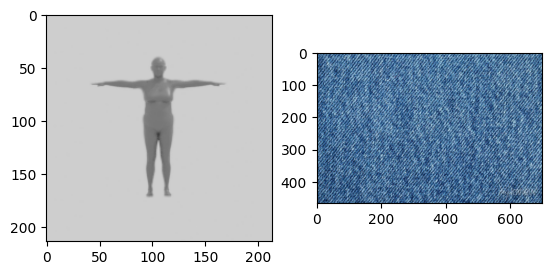

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img);
ax[1].imshow(txt1);

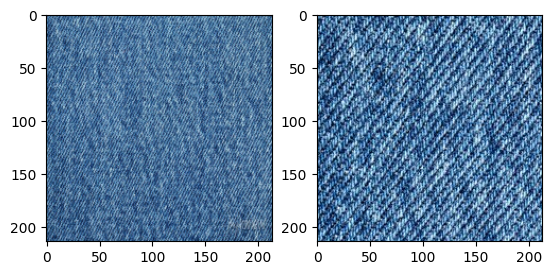

In [5]:
# Resize
resized = cv2.resize(txt1, (int(img.shape[1]), int(img.shape[0])), interpolation=cv2.INTER_AREA)
# Crop
cropped = txt1[0:214, 0:213]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(resized)
ax[1].imshow(cropped);

For the alteration onwards, I choose the texture *resized* from the above and convert its colormap to gray.

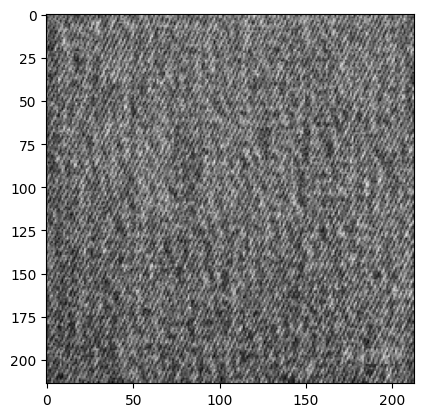

In [6]:
resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)
plt.imshow(resized);

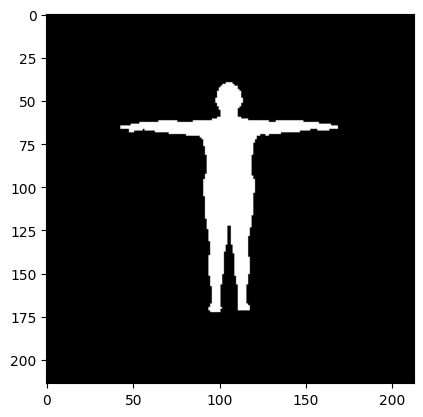

In [7]:
# Create mask profile, background color is 206, our threshold is 190
gray = img.copy()[:, :, 0]
mask = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(mask);

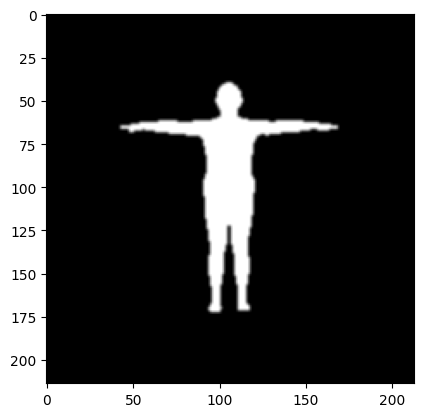

In [8]:
# Blur makes our figure appear larger
mask_blur = cv2.GaussianBlur(mask, (3, 3), 0)
plt.imshow(mask_blur);

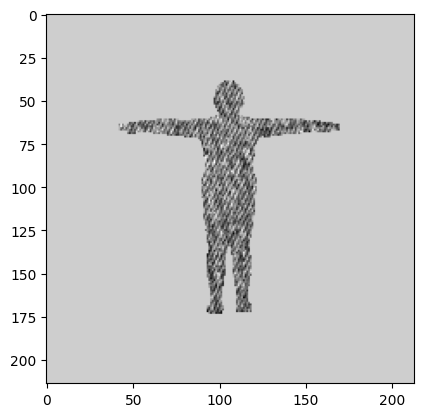

In [9]:
jeans_out = cv2.bitwise_or(resized, resized, mask=mask_blur)
jeans_out = cv2.normalize(jeans_out, jeans_out, 0, 255,
                          cv2.NORM_MINMAX)  #for some reason this isn't accurate, must be checked
jeans_out[mask_blur == 0] = 214  #due to wrong normalization 206 is 214 in this context
plt.imshow(jeans_out);

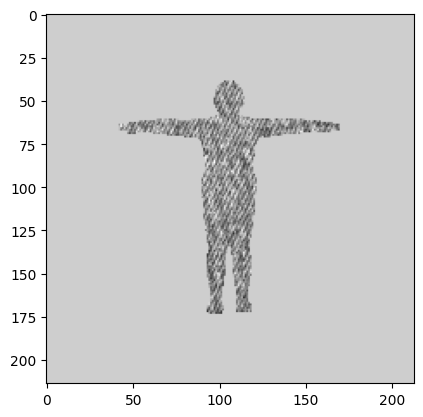

In [11]:
jeans_out1 = cv2.cvtColor(jeans_out, cv2.COLOR_GRAY2RGB)
jeans_out1[mask_blur == 0] = (206, 206, 206)
plt.imshow(jeans_out1);
plt.savefig("jeans_fig.png")

## Script Consodilation

In [18]:
path = '/Users/daniilbarkov/MyProjects/Uni/Pattern2/Unknown.png'
img = cv2.cvtColor(cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/Unknown.png'), cv2.COLOR_BGR2RGB)
txt1 = cv2.cvtColor(cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/texture1.jpg'), cv2.COLOR_BGR2RGB)
resized = cv2.resize(txt1, (int(img.shape[1]), int(img.shape[0])), interpolation=cv2.INTER_AREA)
resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)


def create_mask(img):
    gray = img.copy()[:, :, 0]
    mask = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)[1]  #experiment with threshold, see next cell
    mask_blur = cv2.GaussianBlur(mask, (3, 3), 0)  #experiment with kernel
    return (mask, mask_blur)


def einfarbig(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    mask = create_mask(img)[0]
    img2 = img.copy()
    img2[mask > 0] = (170, 170, 170)
    return img2


def einfarbig_old(img):
    bg_gray = img[10, 10]
    lower_bound = bg_gray - 30
    upper_bound = bg_gray + 30
    mask = cv2.inRange(img, lower_bound, upper_bound)
    mask = cv2.bitwise_not(mask)
    img2 = img.copy()
    img2[mask > 0] = (170, 170, 170)
    return img2


def jeans(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    resized = cv2.resize(txt1, (int(img.shape[1]), int(img.shape[0])), interpolation=cv2.INTER_AREA)
    resized2 = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY)

    gray = img.copy()[:, :, 0]
    mask = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY_INV)[1]  #experiment with threshold, see next cell
    mask_blur = cv2.GaussianBlur(mask, (3, 3), 0)  #experiment with kernel

    img2 = cv2.bitwise_or(resized2, resized2, mask=mask_blur)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    img2[mask == 0] = (206, 206, 206)
    return img2

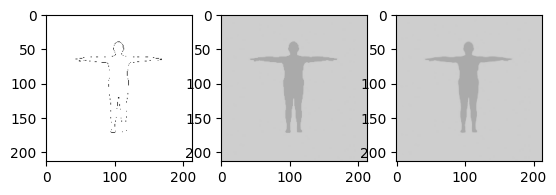

In [19]:
ein1 = einfarbig(path)
ein2 = einfarbig_old(img)
diff = cv2.bitwise_not(ein1 - ein2)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(diff)
ax[1].imshow(ein1)
ax[2].imshow(ein2);

## Apply the Script on the Data Set

In [92]:
import os

path = '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/synthetic_images'

In [96]:
def traverse(root):
    for item in sorted(os.listdir(root)):
        if not item.startswith('.'):
            path_ac = os.path.join(root, item)
            if os.path.isfile(path_ac):
                filename = item[:-4]
                if "male" in path_ac:
                    cv2.imwrite(filename + "-m-ein.png", einfarbig(path_ac))
                    if "ein" not in filename:
                        cv2.imwrite(filename + "-m-jeans.png", jeans(path_ac))
                    if "ein" not in filename and "jeans" not in filename:
                        os.rename(path_ac, filename + "-m.png")
                else:
                    cv2.imwrite(filename + "-f-ein.png", einfarbig(path_ac))
                    if "ein" not in filename:
                        cv2.imwrite(filename + "-f-jeans.png", jeans(path_ac))
                    if "ein" not in filename and "jeans" not in filename:
                        os.rename(path_ac, filename + "-f.png")
                os.chdir(os.path.dirname(path_ac))
            else:
                traverse(path_ac)


traverse(path)

In [94]:
cv2.imwrite("subject_mesh_0001" + "-m-ein.png", einfarbig(
    "/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/synthetic_images/200x200/pose1/male/subject_mesh_0001.png"))

True

In [73]:
import re

path = '/Users/daniilbarkov/MyProjects/Uni/Pattern2/dataset/synthetic_images/200x200/pose0/female'

print(len(sorted(os.listdir(path))))

# for item in sorted(os.listdir(path)):
# print(item)



14999


## Old Method

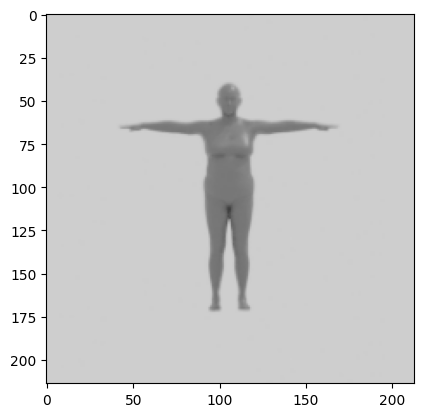

In [79]:
img = cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/Unknown.png')
txt1 = cv2.imread('/Users/daniilbarkov/MyProjects/Uni/Pattern2/texture1.jpg')
txt1 = cv2.cvtColor(txt1, cv2.COLOR_BGR2RGB)

# get image dimensions
h = img.shape[0]  #height
w = img.shape[1]  #width

plt.imshow(img);

In [67]:
img[100, 100]  #grey background color tone

array([120, 120, 120], dtype=uint8)

In [68]:
rand_b = np.random.randint(255)
rand_g = np.random.randint(255)
rand_r = np.random.randint(255)

In [69]:
texture = False
for y in range(0, img.shape[0]):  #looping through each rows
    for x in range(0, img.shape[1]):  #looping through each column
        if (np.abs(img[y, x] - (206, 206, 206)) > 2).any():
            if not texture:
                img[y, x] = (rand_b, rand_g, rand_r)
            else:
                img[y, x] = txt1[y, x]

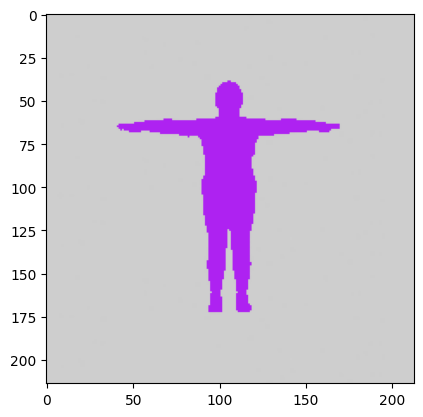

In [70]:
plt.imshow(img);